## Milestone P2 Linguistic Harbingers of Betrayal 
## Julian Leon Raub
### Sciper: 272254

### Context: 

We are given a dataset with a collection of interactions between two parties, half of which end in betrayal and the ohter half being long lasting relationships.The authors already did all the data wrangling for us. This consisted of chosing relationships that contain at least two consecutive and reciprocated acts of support that span at least three seasons in game time, with no more than five seasons passing between two acts of friendship. Out of these chosen relationships they identified the ones that ended in at least two consecutive attacks. These betrayals were then matched with lasting relationships that are nearly identical (in terms of game length etc).

### Structure of the dataset:

The dataset consists of a list of dictionnaries. Each dictionnary being an interaction between two players. 
An interaction has several attributes such as game number, id, the party members involved, if there was a betrayal or not and finally the seasons. The seasons attribute is also a list of dictionnaries in which a dictionnary is represents everything happening in a given season. 
This season dictionnary also has several attributes, like the season number (e.g 1908.5), interaction between two players('support','attack' or 'null') and messages sent during the season (this is also a list of dictionnaries). 
Finally we come down to the last branch of this data set which is the messages sent. This list of dictionnaries contains two dicionnaries for either the betrayer or the victim (accessible through messages['victim'] and messages['betrayer']) each containing a list of messages sent and their respective politeness scores. These politeness score will be used to generate out Barplot. 

#### First we import the necessary libraries

In [1]:
import json
import seaborn as sns
from scipy.stats import sem
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#### Then we open the json dataset 

In [2]:
with open("diplomacy_data.json") as f:
    data = json.load(f)

#### Then we transform the dataset into a DataFrame 
We do this because of personal choice. It is easier to work with Dataframes than with dictionnaries in my opinon.

In [3]:
df = pd.DataFrame(data) #convert data from list of Dict to a DataFrame
df.head(5)

,seasons,game,betrayal,idx,people
0,"[{'season': 1906.5, 'interaction': {'victim': ...",74,True,0,AT
1,"[{'season': 1911.5, 'interaction': {'victim': ...",165,False,1,EG
2,"[{'season': 1911.0, 'interaction': {'victim': ...",157,False,2,AR
3,"[{'season': 1902.0, 'interaction': {'victim': ...",58,False,3,AR
4,"[{'season': 1910.0, 'interaction': {'victim': ...",45,False,4,IT


### Defining useful functions
#### The 3 functions below are used on the dataset from above (called df) and extract relevant informations from it.

#### 1. last_support: 
This function extracts the last support from a player in a given relationship and return the season number for which the last support was given. For example: two players support each other from 1905 to 1907.5 (the .0 for spring and .5 for autumn season) and one attacks at 1908. The function will return 1907.5 as it is the last season of support. 

#### 2. message_politeness
This function averages the politeness score for a given party member on a given season. For example player A  writes 6 messages to player B on season 1905 each message having it's own politeness score, the function will return the average politeness of the 6 messages for player A on season 1905. 

#### 3. add_line 
This function takes adds rows to the plotting_data and imbalance datasets depending on the arguments given to the funciton. Pretty straight forward. 

In [4]:
def last_support(seasons):
    """return the last season where a player supported the other"""
    for season in seasons: #iterate over each season in a relationship
        if 'support' in season['interaction'].values(): #if the word "support" is in the values of interaction then -->
            support = season['season'] # add the number of the season to supp_season 
        
    return support #return the last support season (e.g 1908.5)

In [5]:
def message_politeness(messages):
    """return the average politeness score for a particular player in a season"""
    return sum(m['politeness'] for m in messages)/len(messages)

In [6]:
def message_discourse(messages):
    """return the average number of discourse markers per sentence"""
    n_sents = sum(m['n_sentences'] for m in messages) * 1.0
    return sum(len(m['lexicon_words'].get("disc_temporal_future", [])) for m in messages) / n_sents

In [7]:
def message_sentiment(messages):
    """return positive sentiment average per sentence"""
    n_sents = sum(m['n_sentences'] for m in messages) * 1.0
    return sum(m['sentiment']['positive'] for m in messages)/n_sents

In [40]:
def add_line(data,politeness,discourse,sentiment,relationship,player = None ,imbalance = True):
    """if imbalance is false add a line to the  plotting_data dataset with respective politeness player type and relationship ending
       if imbalance is true add a line to the imbalance data set with only relationship and score"""
    if imbalance:
        data.append({'imbalance':'','imbalance politeness':politeness,'imbalance discourse':discourse,'imbalance sentiment':sentiment,'relationship':relationship})
    else:
        data.append({'Politeness Score':politeness,'Discourse Score':discourse,'Sentiment Score':sentiment,'Player':player,'relationship':relationship})
        

### This is where the magic happens 

#### General procedure 
We need to access the messages['betrayer']['politeness'] and messages['victim']['politeness'] score. This means we need to iterate over the rows of the dataframe, over each season of the seasons attribute and over each message in a given season. 
<u>Sanity check</u>: we do indeed have 3 for loops (2 below and 1 inside the message_politeness function). 

Now, for each season we need to check a certain amount of conditions before getting the politeness scores.
1. if each player sent at least 1 message in the season.
2. if the relationship ends in betrayal or not.
3. if the relationship does end in betrayal we take only the messages up to the last event of support.


In [41]:
plotting_data = [] 
imbalance_data = []

for index,row in df.iterrows(): #iterate over the rows of the dataframe
    
    seasons = row.seasons #define the seasons (see dataframe.head() above)
    last_supp = last_support(seasons) #find the season of the last support 
    
    for season in seasons: #iterate over each season 
        
        # check if the two players had an interaction in every single season
        if len(season['messages']['betrayer']) > 0 and len(season['messages']['victim']) > 0: 
            
            polite_betray = message_politeness(season['messages']['betrayer']) #calculate politeness for betrayer
            polite_vict = message_politeness(season['messages']['victim']) #calculate politeness for victim
            disc_betray = message_discourse(season['messages']['betrayer']) #calculate politeness for betrayer
            disc_vict = message_discourse(season['messages']['victim']) #calculate politeness for victim
            sent_betray = message_sentiment(season['messages']['betrayer']) #calculate politeness for betrayer
            sent_vict = message_sentiment(season['messages']['victim']) #calculate politeness for victim
            #if there is a betrayal take only politeness until last support season 
            if row.betrayal==True and season['season']<=last_supp: 
                
                #append dictionnaries corresponding to all 3 where there is betrayal
                add_line(plotting_data,polite_betray,disc_betray,sent_betray,'betrayal','betrayer',False)
                add_line(plotting_data,polite_vict,disc_vict,sent_vict,'betrayal','victim',False)
                add_line(imbalance_data,polite_betray-polite_vict,disc_betray-disc_vict,sent_betray-sent_vict,'betrayal')

            if row.betrayal== False: 

                #append dictionnaries corresponding to all 3 where there is  no betrayal             
                add_line(plotting_data,polite_betray,disc_betray,sent_betray,'no betrayal','betrayer',False)
                add_line(plotting_data,polite_vict,disc_vict,sent_vict,'no betrayal','victim',False)
                add_line(imbalance_data,polite_betray-polite_vict,disc_betray-disc_vict,sent_betray-sent_vict,'no betrayal')


In [42]:
plotting_data = pd.DataFrame(plotting_data) #convert to DataFrame for plotting (easier to plot using seaborn)
imbalance_data = pd.DataFrame(imbalance_data) #convert to DataFram for plotting (easier to plot using seaborn)
plotting_data.head()

,Politeness Score,Discourse Score,Sentiment Score,Player,relationship
0,0.803328,0.120000,0.320000,betrayer,betrayal
1,0.809993,0.129032,0.193548,victim,betrayal
2,0.560083,0.125000,0.062500,betrayer,betrayal
3,0.785508,0.000000,0.444444,victim,betrayal
4,0.982703,0.307692,0.307692,betrayer,betrayal


### Plotting the data

Finally we can take our two datasets (plotting_data and imbalance_data) and plot then on barplots.
We used Seaborn for this because it is very easy and intuitive. We made sure the two datasets were formatted in a way that we have appropriate x and y axes and what is called a hue (in our case the relationship ending 'betrayal' or 'no betrayal'). 

The bootstraped confidence intervals can also be created with the seaborn function by adjusting the confidence interval to being equal to the range between $[\mu-\sigma;\mu+\sigma] = 68\%$

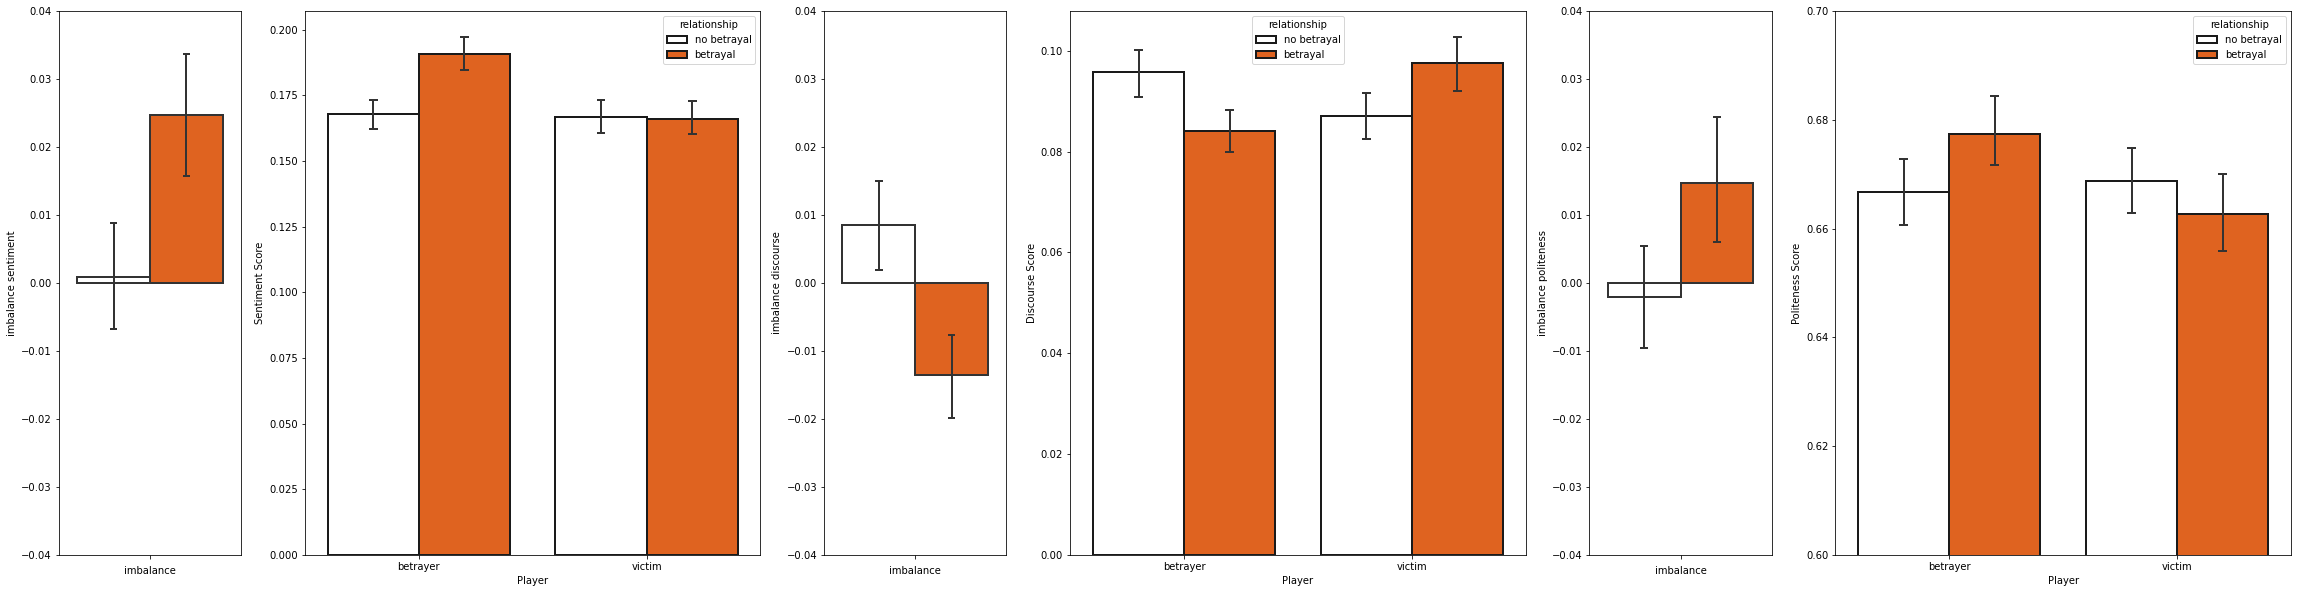

In [58]:
colors = {'no betrayal' : (1,1,1,0),'betrayal' :(1,0.35,0,1)} #Set color palette
fig, axs = plt.subplots(1,6, gridspec_kw={'width_ratios': [2,5,2,5,2,5]}, figsize = (40,10)) #set figure size and subplots
#plot the right graph with bootstrap confidence interval of 68 percent with represents mean +- 1 std 
sns.barplot(x = 'Player',y='Politeness Score',hue = 'relationship',data=plotting_data,ax = axs[5],
            hue_order = ["no betrayal", "betrayal"],ci = 68,capsize = 0.03,
            linewidth=2, errwidth = 2,errcolor=".2", edgecolor=".1", palette = colors)
axs[5].set(ylim=(0.6,0.7)) #set y limits for better viewing 

#plot the left graph with bootstrap confidence interval of 68 percent with represents mean +- 1 std 
sns.barplot(x = 'imbalance',y = 'imbalance politeness', hue = "relationship", data = imbalance_data, ax= axs[4],hue_order = ["no betrayal", "betrayal"], ci = 68, 
            capsize = 0.03, linewidth=2,errwidth = 2,errcolor=".2", edgecolor=".2", palette = colors)
          
axs[4].get_legend().remove() #remove the legend of the left graph because already on the right one 
axs[4].set(ylim=(-0.04,0.04)) #set y limit for better viewing 

sns.barplot(x = 'Player',y='Discourse Score',hue = 'relationship',data=plotting_data,ax = axs[3],
            hue_order = ["no betrayal", "betrayal"],ci = 68,capsize = 0.03,
            linewidth=2, errwidth = 2,errcolor=".2", edgecolor=".1", palette = colors)
#axs[1].set(ylim=(0.6,0.7)) #set y limits for better viewing 

#plot the left graph with bootstrap confidence interval of 68 percent with represents mean +- 1 std 
sns.barplot(x = 'imbalance',y = 'imbalance discourse', hue = "relationship", data = imbalance_data, ax= axs[2],hue_order = ["no betrayal", "betrayal"], ci = 68, 
            capsize = 0.03, linewidth=2,errwidth = 2,errcolor=".2", edgecolor=".2", palette = colors)
          
axs[2].get_legend().remove() #remove the legend of the left graph because already on the right one 
axs[2].set(ylim=(-0.04,0.04)) #set y limit for better viewing 

sns.barplot(x = 'Player',y='Sentiment Score',hue = 'relationship',data=plotting_data,ax = axs[1],
            hue_order = ["no betrayal", "betrayal"],ci = 68,capsize = 0.03,
            linewidth=2, errwidth = 2,errcolor=".2", edgecolor=".1", palette = colors) 

#plot the left graph with bootstrap confidence interval of 68 percent with represents mean +- 1 std 
sns.barplot(x = 'imbalance',y = 'imbalance sentiment', hue = "relationship", data = imbalance_data, ax= axs[0],hue_order = ["no betrayal", "betrayal"], ci = 68, 
            capsize = 0.03, linewidth=2,errwidth = 2,errcolor=".2", edgecolor=".2", palette = colors)
          
axs[0].get_legend().remove() #remove the legend of the left graph because already on the right one 
axs[0].set(ylim=(-0.04,0.04)) #set y limit for better viewing 
#Add general title and save
plt.savefig('all.png')



### General comments about the figure 

As can be seen the figure looks relatively similar to the one in the report. The only exception is the imbalance plot on the no betryal side which seems to go down a bit more in my figure. This might be due to pixel errors since when I tried to make the figure smaller (and the contours a bit thicker) it gave me a smaller bar. The y limits are also different from the original figure.  

In [25]:
df_betrayal = df.loc[df.betrayal == True] #select rows where only betrayals 
df_betrayal.head()

,seasons,game,betrayal,idx,people
0,"[{'season': 1906.5, 'interaction': {'victim': ...",74,True,0,AT
5,"[{'season': 1903.0, 'interaction': {'victim': ...",254,True,5,AG
8,"[{'season': 1905.0, 'interaction': {'victim': ...",153,True,8,GT
9,"[{'season': 1911.0, 'interaction': {'victim': ...",223,True,9,RA
10,"[{'season': 1906.5, 'interaction': {'victim': ...",175,True,10,RI


In [52]:
figure_data = []
figure_imbalance = []

for index,row in df_betrayal.iterrows(): #iterate over the rows of the betrayal dataframe
    
    seasons = row.seasons #define the seasons (see dataframe.head() above)
    last_supp = last_support(seasons) #find the season of the last support
    
    relationship_length = int(2*(last_supp-seasons[0]['season'])+1)
    
    if relationship_length >= 4: #check if support is longer than 4 seasons 
    
        for season in seasons: 

            if len(season['messages']['betrayer']) > 0 and len(season['messages']['victim']) > 0 and season['season'] <= last_supp:
                
                season_number = int(2*(last_supp-season['season'])+1) if int(2*(last_supp-season['season'])+1)<4 else 4
                
                polite_betray = message_politeness(season['messages']['betrayer']) #calculate politeness for betrayer
                polite_vict = message_politeness(season['messages']['victim']) #calculate politeness for victim
                
                figure_data.append({'player':'betrayer','season': season_number ,'politeness':polite_betray})
                figure_data.append({'player':'victim','season': season_number ,'politeness':polite_vict})
                figure_imbalance.append({'season': season_number ,'imbalance':polite_betray-polite_vict})
                

In [53]:
figure_data = pd.DataFrame(figure_data)
figure_imbalance = pd.DataFrame(figure_imbalance)
figure_data.head()

,player,season,politeness
0,betrayer,4,0.803328
1,victim,4,0.809993
2,betrayer,4,0.560083
3,victim,4,0.785508
4,betrayer,4,0.982703


/Users/julianraub/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  


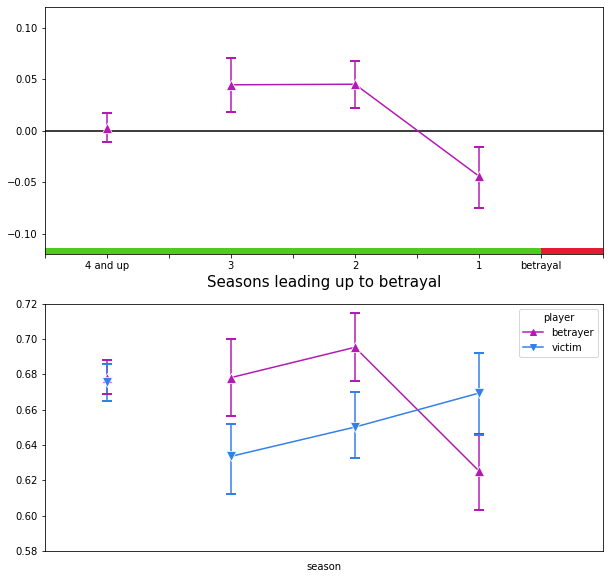

In [54]:
fig,axs = plt.subplots(2,1,figsize=(10,10))
colors = {'betrayer' : (0.7,0.1,0.7,1), 'victim' : (0.2,0.5,0.9,1), 'before' : (0.3,0.8,0.1,1), 'after':(0.9,0.1,0.2,1)}
axs[0].axhline(0,0,4.5,color ='k')
axs[0].set_xlim(4.5,0)
axs[0].set_ylim(-0.12,0.12)
axs[0].set(xticklabels=['', 'betrayal', '1', '', '2', '', '3', '','4 and up', ''])
axs[0].hlines(-0.119, 0.5, 4.5, colors=colors['before'], linestyles='solid', linewidth = 10, label='')
axs[0].hlines(-0.119, 0, 0.5, colors=colors['after'], linestyles='solid', linewidth = 10, label='')

sns.lineplot(x='season',y='imbalance',data=figure_imbalance.loc[figure_imbalance.season<4],err_style = 'bars',
             color = colors['betrayer'], err_kws = {'capsize':5, 'capthick' : 2}, marker = '^', markersize = 10,
             ax = axs[0], ci = 68)

sns.lineplot(x='season',y='imbalance',data=figure_imbalance.loc[figure_imbalance.season==4],err_style = 'bars',
             color = colors['betrayer'], err_kws = {'capsize':5, 'capthick' : 2}, marker = '^', markersize = 10,
             ax = axs[0], ci = 68)

axs[0].set_xlabel('Seasons leading up to betrayal',fontsize = 15.0)
axs[0].set_ylabel('')


axs[1].set_xlim(4.5, 0)
axs[1].set_ylim(0.58, 0.72)
axs[1].tick_params(bottom = False)
axs[1].set(xticklabels = [], xlabel = None)

sns.lineplot(x = 'season',y = 'politeness', hue = 'player', data = figure_data.loc[figure_data.season<4], ax= axs[1],
             err_style = 'bars',style = "player", palette = colors, dashes = False, ci = 68,
             markers = {'betrayer':'^', 'victim':'v'}, markersize = 10, err_kws = {'capsize':5, 'capthick' : 2})

sns.lineplot(x = 'season',y = 'politeness', hue = 'player', data = figure_data.loc[figure_data.season==4], ax= axs[1],
             err_style = 'bars',legend=False,style = "player", palette = colors, dashes = False, ci = 68,
             markers = {'betrayer':'^', 'victim':'v'}, markersize = 10, err_kws = {'capsize':5, 'capthick' : 2})
axs[1].set_ylabel('')
plt.show()
